In [49]:
import copy
import logging

import matplotlib.pyplot as plt
import pandas as pd

from data.handler.EventLogHandler import EventLogHandler
from utils.Path import Path

logging.basicConfig(level=logging.WARNING)

handler = EventLogHandler()
handler.load(str(Path(['resources', 'test_logs', 'bpi2011_prep.xes'])))

parsing log, completed traces ::   0%|          | 0/200 [00:00<?, ?it/s]

In [62]:
import datetime

from ml.encoding.EventLogEncodingBuilder import EventLogEncodingBuilder
from ml.encoding.intercase.AverageDelay import AverageDelay
from ml.encoding.intercase.FrequentPreviousActivity import FrequentPreviousActivity
from ml.encoding.intercase.FutureBatchingBehaviour import FutureBatchingBehaviour
from ml.encoding.intercase.NoPeerCases import NoPeerCases
from ml.encoding.intercase.PeerActivityCount import PeerActivityCount
from ml.encoding.intercase.ResourceCount import ResourceCount
from ml.encoding.intercase.TopBusyResource import TopBusyResource
from ml.encoding.intracase.IndexBasedEncoder import IndexBasedEncoder
from ml.classifier.NGram import NGram

def get_full_dataframe(handler_, timedelta_, min_batch_size_=10, max_delay_factor_=0.1):
    handler_ = copy.deepcopy(handler_)
    handler_.mine_batching_patterns(min_batch_size=min_batch_size_, max_delay=max_delay_factor_ * timedelta_)

    ngram = NGram(max_classes=len(handler_.process_definition))
    ngram_builder = EventLogEncodingBuilder() \
        .add(IndexBasedEncoder(window=4))


    X_ngram, y_ngram = ngram_builder.build(handler_)

    ngram.fit(X_ngram, y_ngram)

    builder = EventLogEncodingBuilder() \
        .add(IndexBasedEncoder(window=4)) \
        .add(NoPeerCases(timeframe=timedelta_)) \
        .add(PeerActivityCount(timeframe=timedelta_)) \
        .add(ResourceCount(timeframe=timedelta_)) \
        .add(AverageDelay(timeframe=timedelta_)) \
        .add(FrequentPreviousActivity(timeframe=timedelta_, no_activities=2, normalization=True)) \
        .add(TopBusyResource(timeframe=timedelta_, no_resources=2, normalization=True)) \
        .add(FutureBatchingBehaviour(segment_classifier=ngram, segment_encoding_builder=ngram_builder,
                                     include_average_times=False)) \

    X, y = builder.build(handler_)

    df_values = {}

    for j_ in range(4):
        df_values[f'index_based_{j_}'] = X[:, j_]
    df_values['peer_cases'] = X[:, 4]
    df_values['peer_act'] = X[:, 5]
    df_values['res_count'] = X[:, 6]
    df_values['avg_delay'] = X[:, 7]
    df_values['freq_act_1'] = X[:, 8]
    df_values['freq_act_2'] = X[:, 9]
    df_values['top_res_1'] = X[:, 10]
    df_values['top_res_2'] = X[:, 11]
    df_values['batch'] = X[:, 12]
    df_values['y'] = y

    df_ = pd.DataFrame(df_values)

    def min_max_scaling(series):
        return (series - series.min()) / (series.max() - series.min())

    for col in ['peer_cases', 'peer_act', 'res_count', 'avg_delay']:
        df_[col] = min_max_scaling(df_[col])

    return df_

In [63]:
MEDIAN_CASE_TIME = 27.1

In [65]:
timedeltas = [datetime.timedelta(weeks=0.1 * MEDIAN_CASE_TIME),
              datetime.timedelta(weeks=0.15 * MEDIAN_CASE_TIME),
              datetime.timedelta(weeks=0.25 * MEDIAN_CASE_TIME),
              datetime.timedelta(weeks=0.5 * MEDIAN_CASE_TIME),
              datetime.timedelta(weeks=0.75 * MEDIAN_CASE_TIME)]

max_delay_factors = [0.05, 0.1, 0.15, 0.5]
min_batch_sizes = [5, 10, 20, 50]

dfs = {}
for i1_, timedelta in enumerate(timedeltas):
    for i2_, max_delay_factor in enumerate(max_delay_factors):
        for i3_, min_batch_size in enumerate(min_batch_sizes):
            print(f'{i1_}+{i2_}+{i3_}')
            dfs[f'{i1_}+{i2_}+{i3_}'] = get_full_dataframe(handler, timedelta, max_delay_factor_=max_delay_factor, min_batch_size_=min_batch_size)

0+0+0
0+0+1
0+0+2
0+0+3
0+1+0
0+1+1
0+1+2
0+1+3
0+2+0
0+2+1
0+2+2
0+2+3
0+3+0
0+3+1
0+3+2
0+3+3
1+0+0
1+0+1
1+0+2
1+0+3
1+1+0
1+1+1
1+1+2
1+1+3
1+2+0
1+2+1
1+2+2
1+2+3
1+3+0
1+3+1
1+3+2
1+3+3
2+0+0
2+0+1
2+0+2
2+0+3
2+1+0
2+1+1
2+1+2
2+1+3
2+2+0
2+2+1
2+2+2
2+2+3
2+3+0
2+3+1
2+3+2
2+3+3
3+0+0
3+0+1
3+0+2
3+0+3
3+1+0
3+1+1
3+1+2
3+1+3
3+2+0
3+2+1
3+2+2
3+2+3
3+3+0
3+3+1
3+3+2
3+3+3
4+0+0
4+0+1
4+0+2
4+0+3
4+1+0
4+1+1
4+1+2
4+1+3
4+2+0
4+2+1
4+2+2
4+2+3
4+3+0
4+3+1
4+3+2
4+3+3


In [58]:
%matplotlib inline

0+0+0


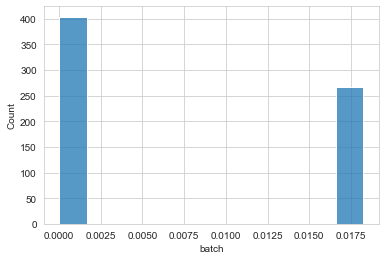

0+0+1


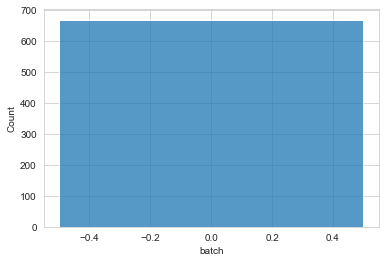

0+0+2


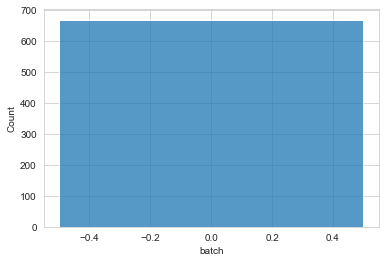

0+0+3


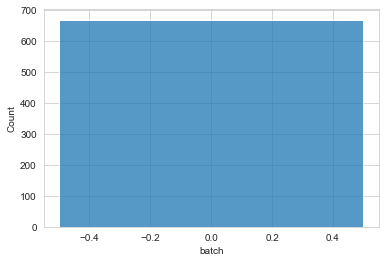

0+1+0


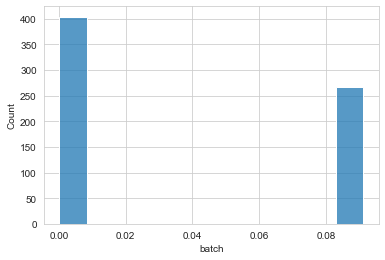

0+1+1


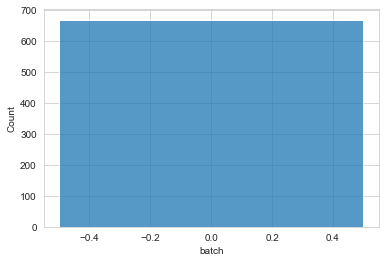

0+1+2


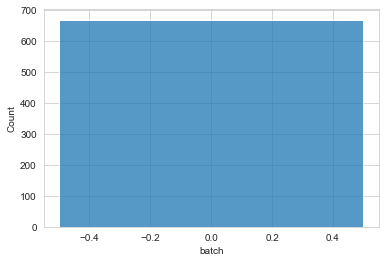

0+1+3


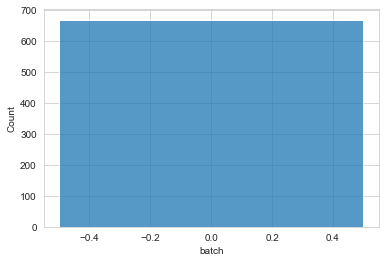

0+2+0


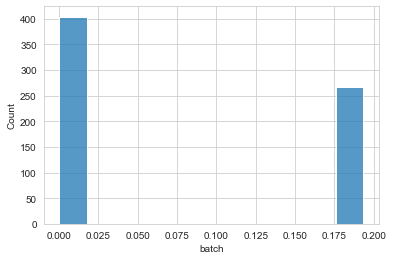

0+2+1


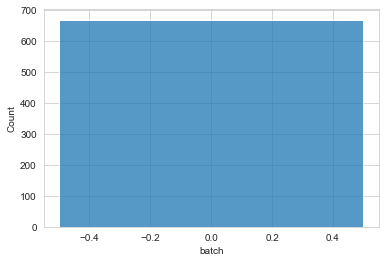

0+2+2


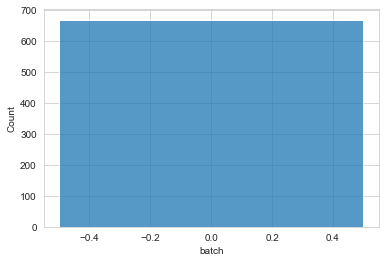

0+2+3


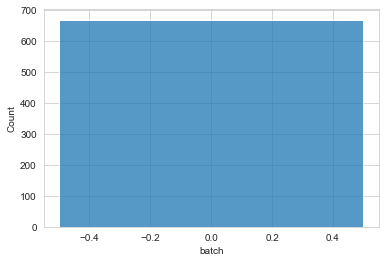

0+3+0


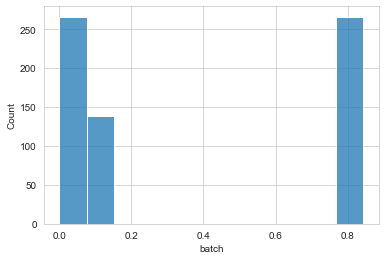

0+3+1


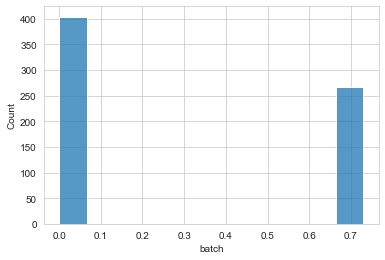

0+3+2


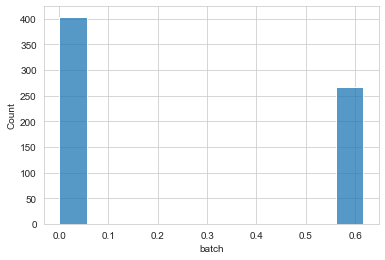

0+3+3


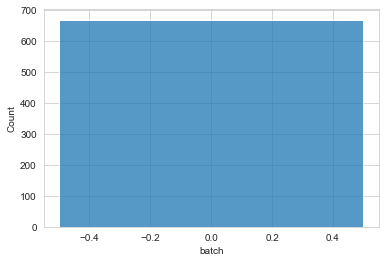

1+0+0


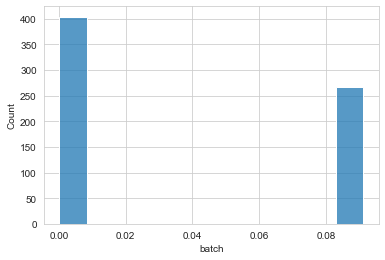

1+0+1


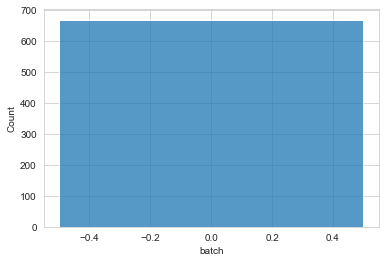

1+0+2


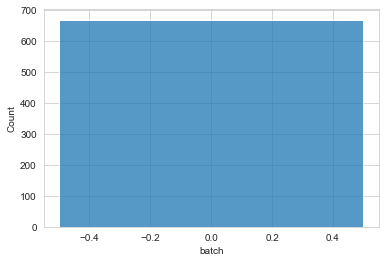

1+0+3


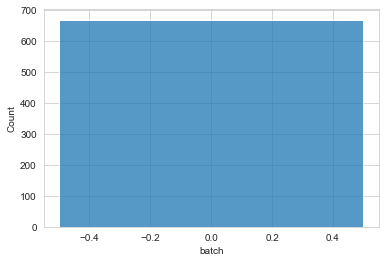

1+1+0


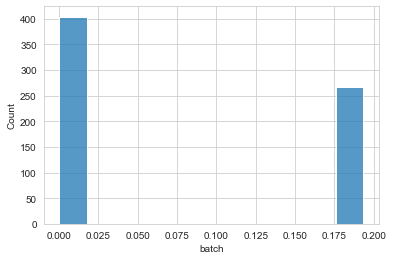

1+1+1


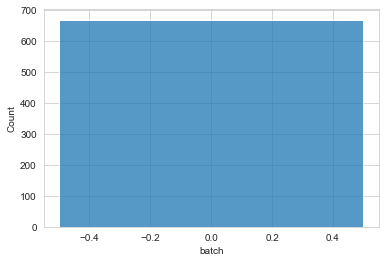

1+1+2


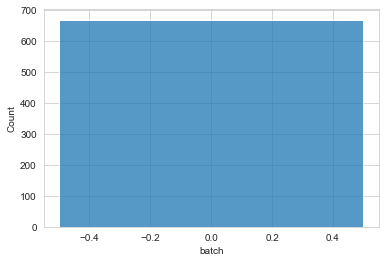

1+1+3


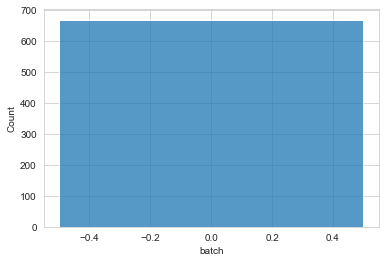

1+2+0


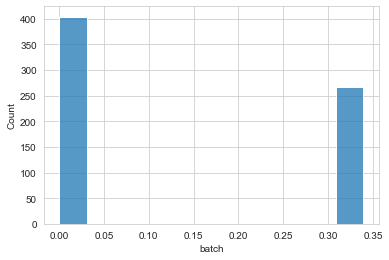

1+2+1


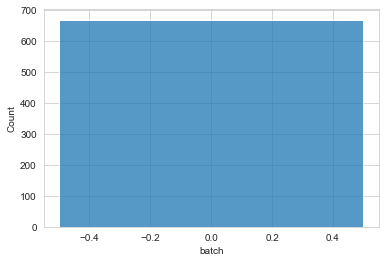

1+2+2


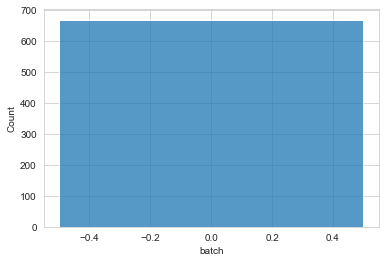

1+2+3


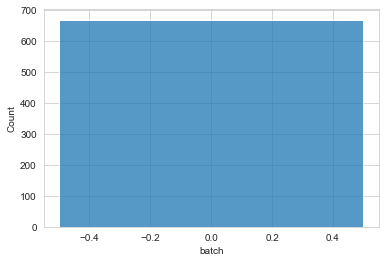

1+3+0


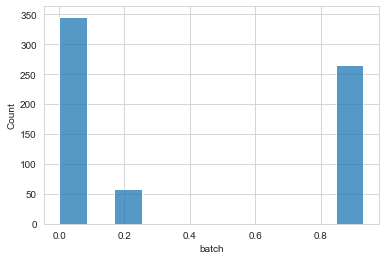

1+3+1


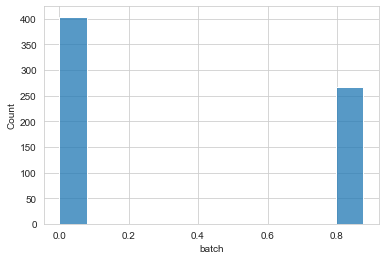

1+3+2


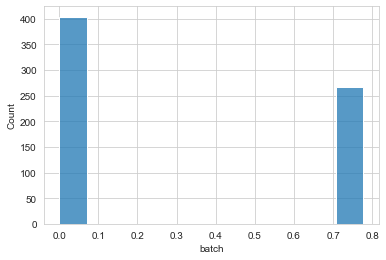

1+3+3


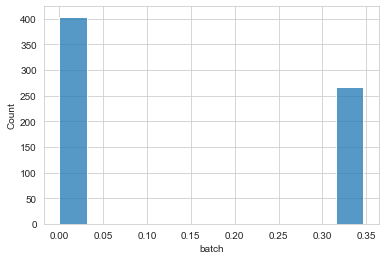

2+0+0


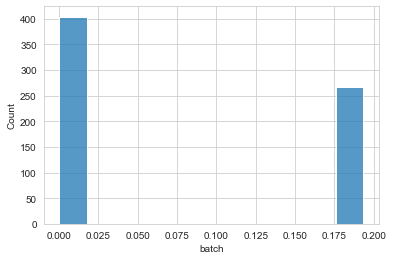

2+0+1


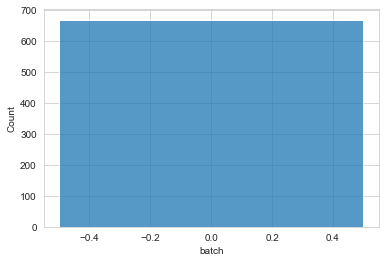

2+0+2


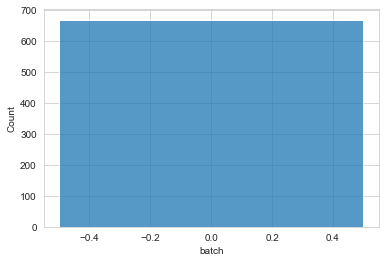

2+0+3


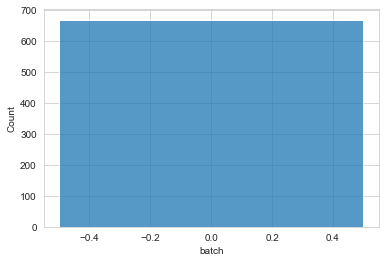

2+1+0


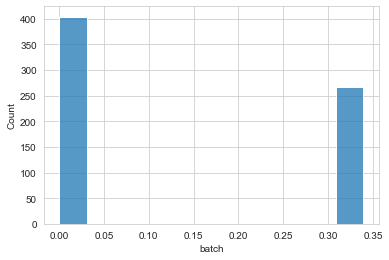

2+1+1


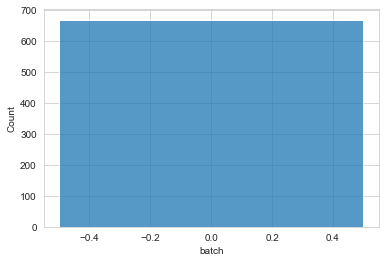

2+1+2


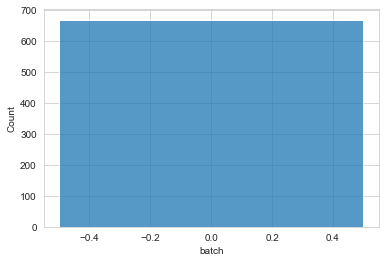

2+1+3


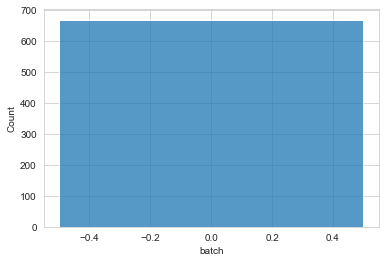

2+2+0


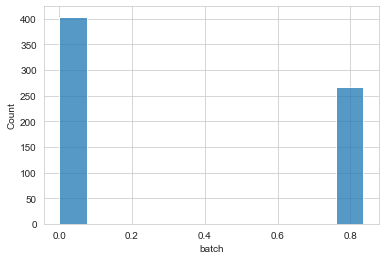

2+2+1


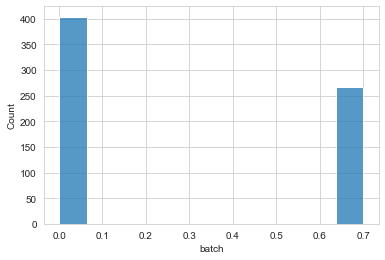

2+2+2


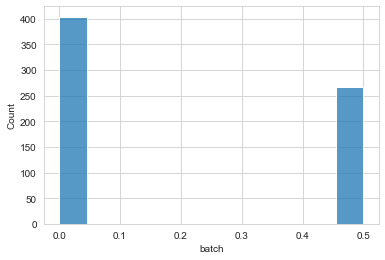

2+2+3


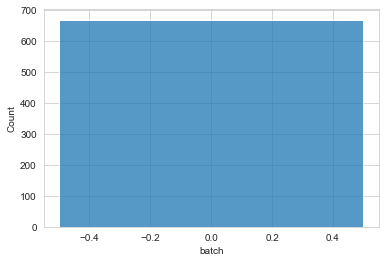

2+3+0


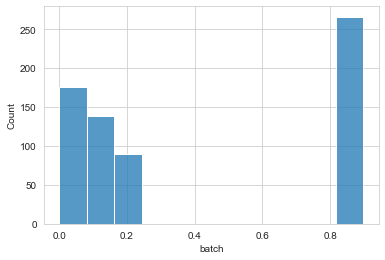

2+3+1


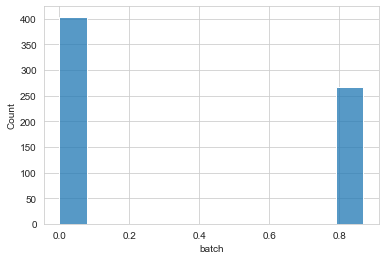

2+3+2


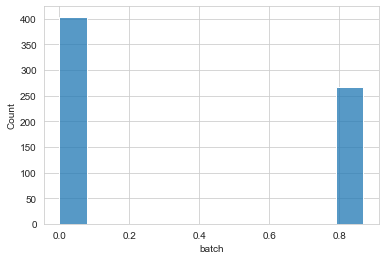

2+3+3


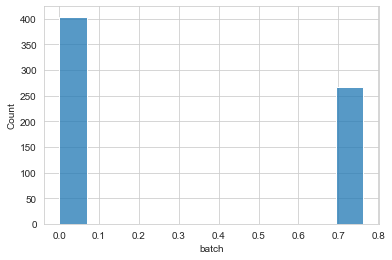

3+0+0


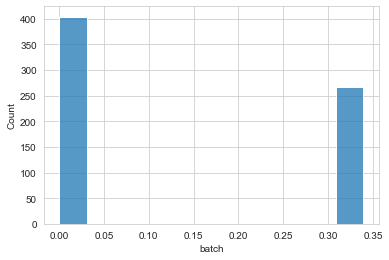

3+0+1


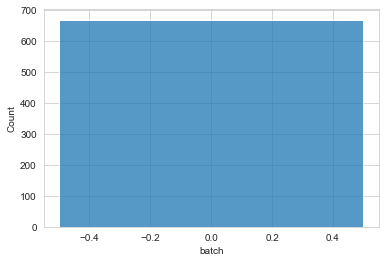

3+0+2


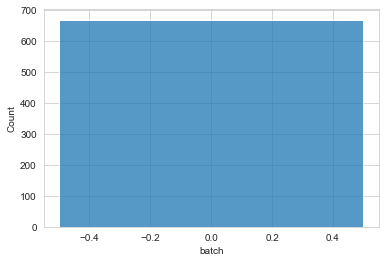

3+0+3


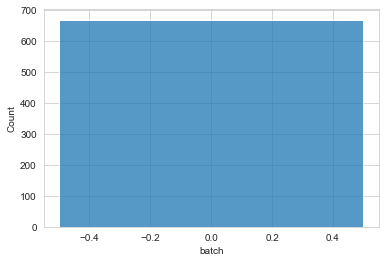

3+1+0


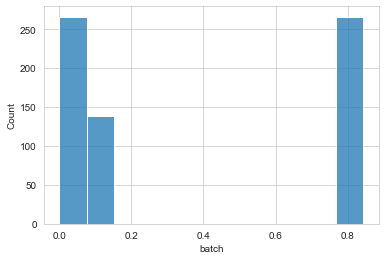

3+1+1


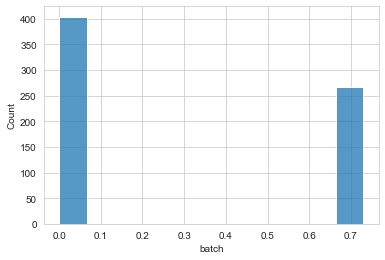

3+1+2


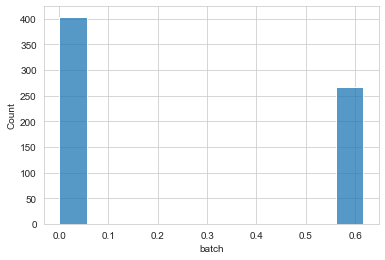

3+1+3


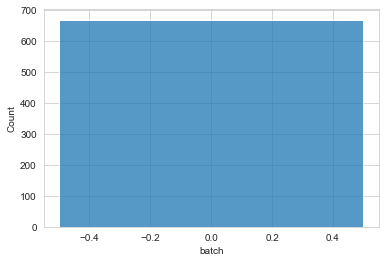

3+2+0


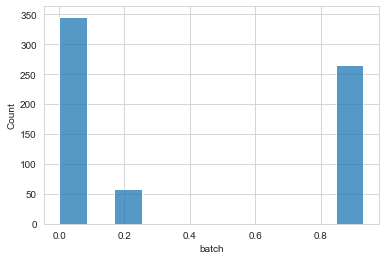

3+2+1


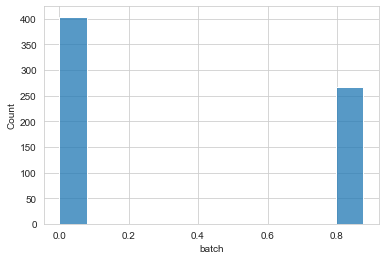

3+2+2


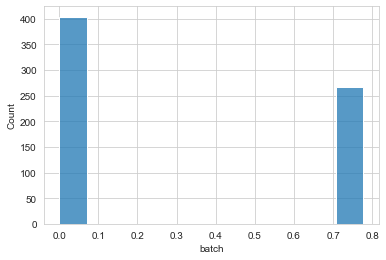

3+2+3


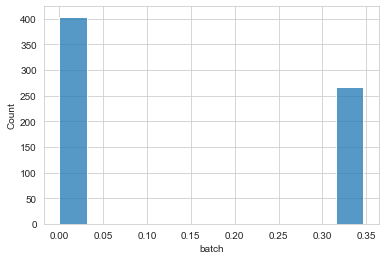

3+3+0


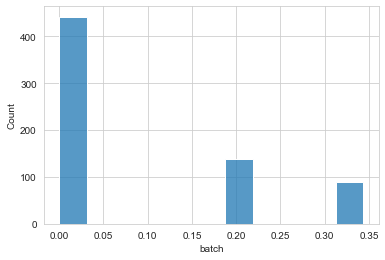

3+3+1


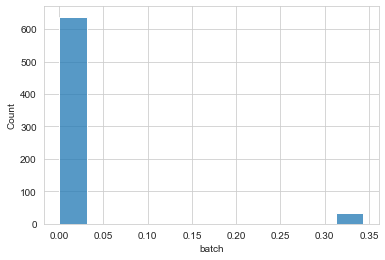

3+3+2


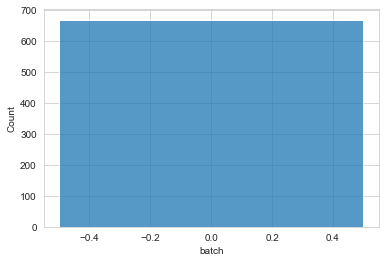

3+3+3


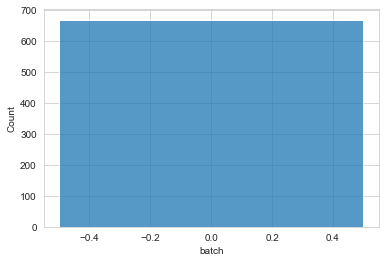

4+0+0


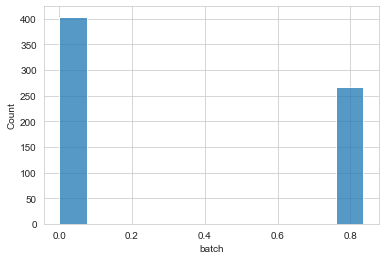

4+0+1


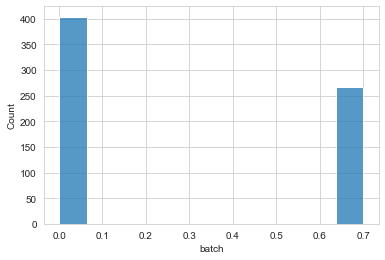

4+0+2


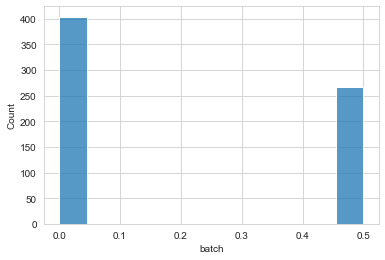

4+0+3


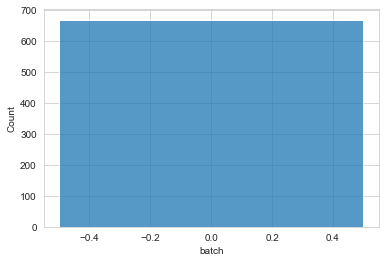

4+1+0


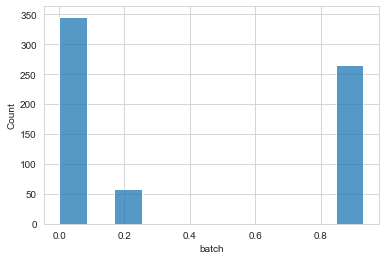

4+1+1


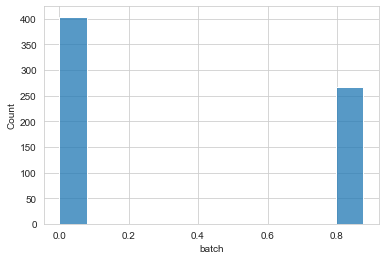

4+1+2


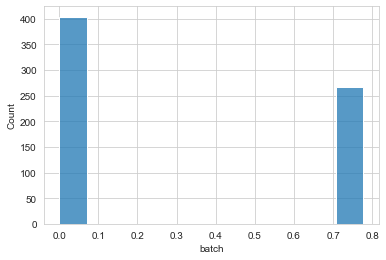

4+1+3


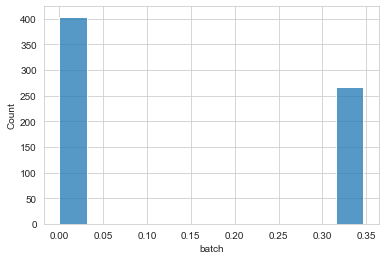

4+2+0


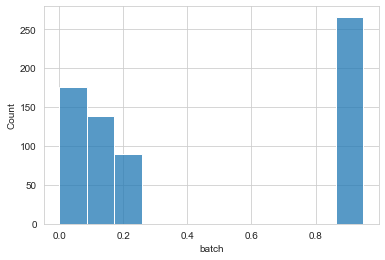

4+2+1


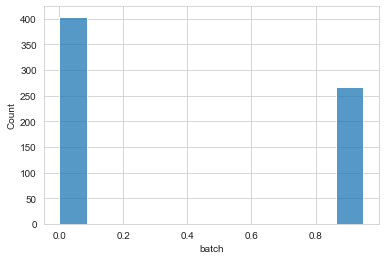

4+2+2


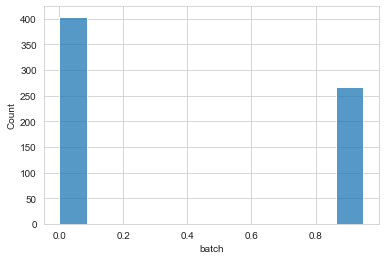

4+2+3


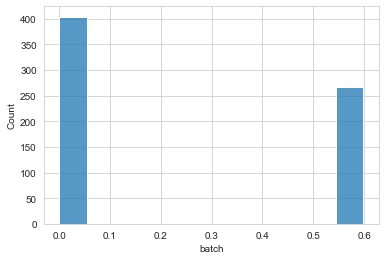

4+3+0


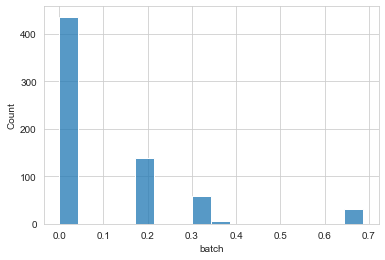

4+3+1


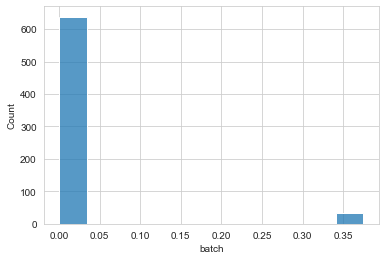

4+3+2


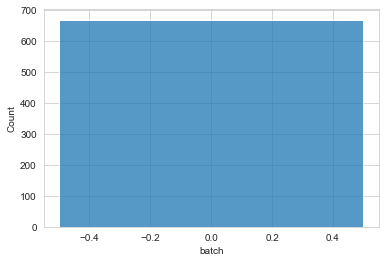

4+3+3


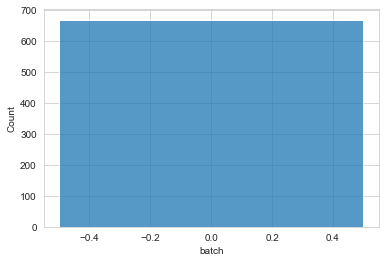

In [67]:
import seaborn as sns

for df_key, df_value in dfs.items():
    print(df_key)
    sns.histplot(df_value['batch'])
    plt.show()
    plt.close()

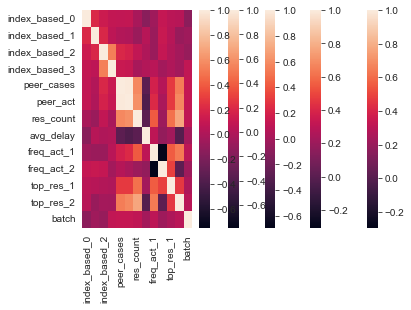

In [34]:
import seaborn as sns

for df in dfs.values():
    sns.heatmap(df.corr())

In [68]:
from statsmodels.formula.api import ols
from functools import reduce

def regression_model_test(df_, label_, model_vars_):
    model_vars_string_ = reduce(lambda a, b: a + ' + '  + b, model_vars_)
    model_ = f'{label_} ~ {model_vars_string_}'
    lm_    = ols(formula = model_, data = df_).fit()
    print(lm_.rsquared, lm_.rsquared_adj, model_vars_string_)
    return [model_vars_, lm_.rsquared, lm_.rsquared_adj]

In [69]:
from itertools import combinations

df_ = dfs['4+2+0']

variables = df_.columns[:-1]

parameters = []
# We iterate over all possible combinations of variables
label = 'y'
for i in range(1, len(variables)):
    for model_vars in combinations(variables, i):
        parameters.append(regression_model_test(df_, label, model_vars))

0.7476952184674477 0.7473175166986864 index_based_0
0.781724950104266 0.7813981910475358 index_based_1
0.7841779069925258 0.7838548200269457 index_based_2
0.7484393815624404 0.7480627938102884 index_based_3
0.07454839693890458 0.07316299034749574 peer_cases
0.05131054486534181 0.0498903510702301 peer_act
0.07011490575037838 0.06872286219611246 res_count
0.07436961235202899 0.07298393811902304 avg_delay
0.00028621924722727066 -0.0012103582688696157 freq_act_1
0.0006328676322440163 -0.0008631909491447765 freq_act_2
0.0005242258891489104 -0.0009719953295799222 top_res_1
0.012585495566451832 0.011107330140653127 top_res_2
0.13713533123042498 0.13584361765442265 batch
0.7861299588267234 0.785488669347943 index_based_0 + index_based_1
0.787991771206714 0.7873560643737507 index_based_0 + index_based_2
0.7756691074939325 0.7749964511445889 index_based_0 + index_based_3
0.7542608843436328 0.753524035421125 index_based_0 + peer_cases
0.7533289213963498 0.7525892779822458 index_based_0 + peer_act

In [70]:
parameters

[[('index_based_0',), 0.7476952184674477, 0.7473175166986864],
 [('index_based_1',), 0.781724950104266, 0.7813981910475358],
 [('index_based_2',), 0.7841779069925258, 0.7838548200269457],
 [('index_based_3',), 0.7484393815624404, 0.7480627938102884],
 [('peer_cases',), 0.07454839693890458, 0.07316299034749574],
 [('peer_act',), 0.05131054486534181, 0.0498903510702301],
 [('res_count',), 0.07011490575037838, 0.06872286219611246],
 [('avg_delay',), 0.07436961235202899, 0.07298393811902304],
 [('freq_act_1',), 0.00028621924722727066, -0.0012103582688696157],
 [('freq_act_2',), 0.0006328676322440163, -0.0008631909491447765],
 [('top_res_1',), 0.0005242258891489104, -0.0009719953295799222],
 [('top_res_2',), 0.012585495566451832, 0.011107330140653127],
 [('batch',), 0.13713533123042498, 0.13584361765442265],
 [('index_based_0', 'index_based_1'), 0.7861299588267234, 0.785488669347943],
 [('index_based_0', 'index_based_2'), 0.787991771206714, 0.7873560643737507],
 [('index_based_0', 'index_ba

In [71]:
df_parameters = pd.DataFrame(parameters)

In [72]:
df_parameters

0         1         2
0                                      (index_based_0,)  0.747695  0.747318
1                                      (index_based_1,)  0.781725  0.781398
2                                      (index_based_2,)  0.784178  0.783855
3                                      (index_based_3,)  0.748439  0.748063
4                                         (peer_cases,)  0.074548  0.073163
...                                                 ...       ...       ...
8185  (index_based_0, index_based_1, index_based_2, ...  0.798394  0.794712
8186  (index_based_0, index_based_1, index_based_2, ...  0.798242  0.794557
8187  (index_based_0, index_based_1, index_based_3, ...  0.795767  0.792037
8188  (index_based_0, index_based_2, index_based_3, ...  0.795866  0.792137
8189  (index_based_1, index_based_2, index_based_3, ...  0.796768  0.793056

[8190 rows x 3 columns]

In [73]:
df_parameters.sort_values(2)

0         1         2
367                 (freq_act_1, freq_act_2, top_res_1)  0.001562 -0.002935
82                              (freq_act_1, top_res_1)  0.000705 -0.002292
81                             (freq_act_1, freq_act_2)  0.000946 -0.002049
85                              (freq_act_2, top_res_1)  0.001061 -0.001935
8                                         (freq_act_1,)  0.000286 -0.001210
...                                                 ...       ...       ...
4246  (index_based_0, index_based_1, index_based_2, ...  0.797580  0.795439
7183  (index_based_0, index_based_1, index_based_2, ...  0.798270  0.795519
6022  (index_based_0, index_based_1, index_based_2, ...  0.798009  0.795564
7186  (index_based_0, index_based_1, index_based_2, ...  0.798353  0.795603
6025  (index_based_0, index_based_1, index_based_2, ...  0.798093  0.795649

[8190 rows x 3 columns]

In [75]:
df_parameters['len_parameters'] = df_parameters[0].apply(len)

In [76]:
df_parameters

0         1         2  \
0                                      (index_based_0,)  0.747695  0.747318   
1                                      (index_based_1,)  0.781725  0.781398   
2                                      (index_based_2,)  0.784178  0.783855   
3                                      (index_based_3,)  0.748439  0.748063   
4                                         (peer_cases,)  0.074548  0.073163   
...                                                 ...       ...       ...   
8185  (index_based_0, index_based_1, index_based_2, ...  0.798394  0.794712   
8186  (index_based_0, index_based_1, index_based_2, ...  0.798242  0.794557   
8187  (index_based_0, index_based_1, index_based_3, ...  0.795767  0.792037   
8188  (index_based_0, index_based_2, index_based_3, ...  0.795866  0.792137   
8189  (index_based_1, index_based_2, index_based_3, ...  0.796768  0.793056   

      len_parameters  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1  
...              ...  
8185              12  
8186              12  
8187              12  
8188              12  
8189              12  

[8190 rows x 4 columns]

In [81]:
df_parameters.columns

Index([0, 1, 2, 'len_parameters'], dtype='object')

In [82]:
df_parameters['r_squared_adj'] = df_parameters[2]

<AxesSubplot:xlabel='len_parameters', ylabel='r_squared_adj'>

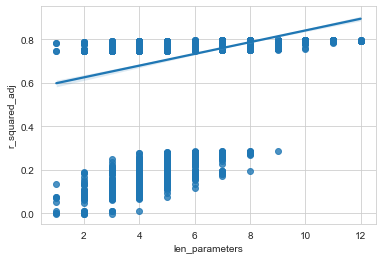

In [83]:
sns.regplot(data=df_parameters, x='len_parameters', y='r_squared_adj')

In [97]:
intercase_features = set(dfs['0+0+0'].columns[:4])
intracase_features = set(dfs['0+0+0'].columns[4:-1])

In [98]:
intracase_features

{'avg_delay',
 'batch',
 'freq_act_1',
 'freq_act_2',
 'peer_act',
 'peer_cases',
 'res_count',
 'top_res_1',
 'top_res_2'}

In [100]:
df_parameters['variables'] = df_parameters[0]

In [112]:
df_parameters['is_intercase'] = len(set(df_parameters['variables']).intersection(intercase_features))

In [113]:
df_parameters

0         1         2  \
0                                      (index_based_0,)  0.747695  0.747318   
1                                      (index_based_1,)  0.781725  0.781398   
2                                      (index_based_2,)  0.784178  0.783855   
3                                      (index_based_3,)  0.748439  0.748063   
4                                         (peer_cases,)  0.074548  0.073163   
...                                                 ...       ...       ...   
8185  (index_based_0, index_based_1, index_based_2, ...  0.798394  0.794712   
8186  (index_based_0, index_based_1, index_based_2, ...  0.798242  0.794557   
8187  (index_based_0, index_based_1, index_based_3, ...  0.795767  0.792037   
8188  (index_based_0, index_based_2, index_based_3, ...  0.795866  0.792137   
8189  (index_based_1, index_based_2, index_based_3, ...  0.796768  0.793056   

      len_parameters  r_squared_adj  \
0                  1       0.747318   
1                  1       0.781398   
2                  1       0.783855   
3                  1       0.748063   
4                  1       0.073163   
...              ...            ...   
8185              12       0.794712   
8186              12       0.794557   
8187              12       0.792037   
8188              12       0.792137   
8189              12       0.793056   

                                              variables  is_intercase  
0                                      (index_based_0,)             0  
1                                      (index_based_1,)             0  
2                                      (index_based_2,)             0  
3                                      (index_based_3,)             0  
4                                         (peer_cases,)             0  
...                                                 ...           ...  
8185  (index_based_0, index_based_1, index_based_2, ...             0  
8186  (index_based_0, index_based_1, index_based_2, ...             0  
8187  (index_based_0, index_based_1, index_based_3, ...             0  
8188  (index_based_0, index_based_2, index_based_3, ...             0  
8189  (index_based_1, index_based_2, index_based_3, ...             0  

[8190 rows x 7 columns]